In [13]:
import numpy as np
import pandas as pd
import os, sys
from astropy import units as u
import random
import h5py
import itertools
import pickle
import glob

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=30)
rc('ytick', labelsize=30)

import tess_binaries as tb

from scipy.signal import find_peaks

### Read in training sample files

In [2]:
sample = tb.loadSampleFromHDF5(f'{tb.cat_dir}/asassn_tess_inspected.hdf5')

Loading /astro/users/jbirky/projects/tess_binaries/catalogs/asassn_tess_inspected.hdf5


In [26]:
lc_files = glob.glob('light_curves/*')
ps_files = glob.glob('power_spectra/*')

### LS Periodogram feature extraction

In [166]:
def extractPeriodogramFeatures(ps, npeaks=5, width=1, distance=100):
    period, power = ps
    peaks, properties = find_peaks(power, width=width, distance=distance)

    best_powers = np.sort(power[peaks])[::-1][:npeaks]
    best_ind = np.array([np.where(power == bp)[0][0] for bp in best_powers])
    best_periods = period[best_ind]
    best_widths = properties["widths"][np.argsort(power[peaks])[::-1][:npeaks]]
    
    features = np.array([best_periods, best_powers, best_widths])
    
    return best_periods, features.flatten()

In [167]:
ID = sample['tic_id'][0]
ps = np.load(f'power_spectra/{ID}.npy')

extractPeriodogramFeatures(ps, npeaks=5)

(array([1.39773357, 0.69880806, 1.55814928, 1.26636627, 0.46585899]),
 array([1.39773357e+00, 6.98808056e-01, 1.55814928e+00, 1.26636627e+00,
        4.65858988e-01, 8.75562560e-01, 5.23480212e-02, 1.75666678e-02,
        1.75587431e-02, 7.64851268e-03, 8.40697407e+00, 8.45131542e+00,
        1.17028400e+01, 1.16801582e+01, 8.32087205e+00]))

In [169]:
lbl_names = ['per_LS1', 'per_LS2', 'per_LS3', 'per_LS4', 'per_LS5', \
 'pow_LS1', 'pow_LS2', 'pow_LS3', 'pow_LS4', 'pow_LS5' \
 'wid_LS1', 'wid_LS2', 'wid_LS3', 'wid_LS4', 'wid_LS5']

In [170]:
periods, features = [], []

for ID in sample['tic_id']:

    ps = np.load(f'power_spectra/{ID}.npy')
    per, feat = extractPeriodogramFeatures(ps, npeaks=5)
    
    periods.append(per)
    features.append(feat)
    
periods, features = np.array(periods), np.array(features)

In [176]:
dic = {}
for i in range(len(lbl_names)):
    dic[lbl_names[i]] = features.T[i]
dic['tic_id'] = sample['tic_id']

In [178]:
ls_features = pd.DataFrame(data=dic)
ls_features.to_csv('ls_features.csv')

#### visualize peaks:

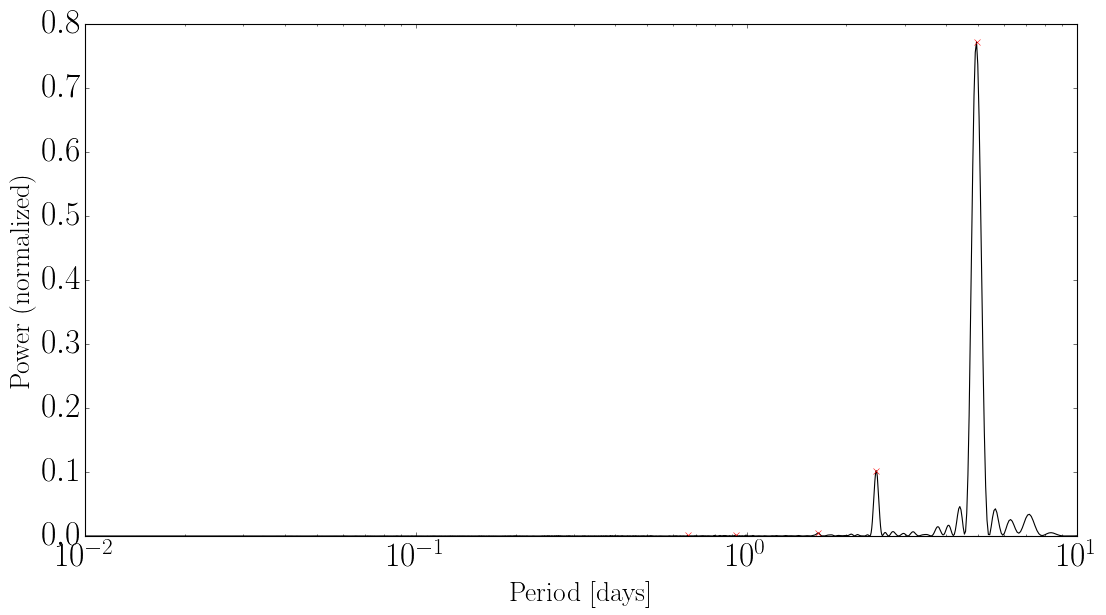

In [332]:
npeaks = 5

# ID = sample['tic_id'][4]

for ID in sample['tic_id'][51:52]:
    period, power = np.load(f'power_spectra/{ID}.npy')

    peaks, properties = find_peaks(power, width=1, distance=100)

    best_powers = np.sort(power[peaks])[::-1][:npeaks]
    best_ind = np.array([np.where(power == bp)[0][0] for bp in best_powers])
    best_periods = period[best_ind]
    best_widths = properties["widths"][np.argsort(power[peaks])[::-1][:npeaks]]

    plt.figure(figsize=[16,8])
    plt.plot(period, power, color='k')
    plt.plot(best_periods, best_powers, "x", color='r', linewidth=30)
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.xscale('log')
    plt.xlim(.01,10)
    plt.xlabel('Period [days]', fontsize=25)
    plt.ylabel('Power (normalized)', fontsize=25)
    plt.show()

In [427]:
(1004-279)/1004

0.7221115537848606

### Extract light curve features

In [199]:
def extractLightCurveFeatures(lc):
    time, flux = lc
    features = np.array([
        np.nanmin(flux),
        np.nanmax(flux),
        np.nanmean(flux),
        np.nanstd(flux),
        np.nanpercentile(flux,5),
        np.nanpercentile(flux,50),
        np.nanpercentile(flux,95)
    ])
    
    return features

In [226]:
lc_labels = ['lc_min', 'lc_max', 'lc_mean', 'lc_std', 'lc_p5', 'lc_perc50', 'lc_perc95']

In [200]:
lc = np.load(f"light_curves/{sample['tic_id'][0]}.npy")

extractLightCurveFeatures(lc)

array([ 368.9491272 , 1028.26367188,  740.02599017,  129.09849933,
        507.16000366,  772.93432617,  901.20811462])

In [205]:
lc_features = []

for ID in sample['tic_id']:
    lc = np.load(f'light_curves/{ID}.npy')
    feat = extractLightCurveFeatures(lc)
    lc_features.append(feat)
    
lc_features = np.array(lc_features)

In [227]:
len(lc_labels)

7

In [228]:
dic = {}
for i in range(len(lc_labels)):
    dic[lc_labels[i]] = lc_features.T[i]
dic['tic_id'] = sample['tic_id']

In [231]:
lc_features = pd.DataFrame(data=dic)
lc_features.to_csv('lc_features.csv')

### Convert training periods to label vector

In [326]:
# format: [LS_1, LS_2, LS_3, LS_4, LS_5, ACF]

pmat = np.concatenate((periods, np.array([list(acf_feat['P_avg'])]).T), axis=1)
ptrue = sample['period']

lvector = np.zeros(pmat.shape)

for i in range(pmat.shape[0]):
    for j in range(pmat.shape[1]):
        if np.abs(pmat[i,j] - ptrue[i]) < .1:
            lvector[i,j] = 1
        else:
            lvector[i,j] = 0

In [318]:
lvector.shape

(1004, 6)

In [327]:
lvector

array([[0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [328]:
a = 0
for v in lvector:
    if np.sum(v) == 0:
        a += 1
print(a)

229


### Combine all of the features

In [274]:
acf_feat = pd.read_csv('acf_features.csv').drop(['Rsq_k', 'B_k', 'A_k', 'P_k', 'Unnamed: 0'], axis=1)
lc_feat  = pd.read_csv('lc_features.csv').drop(['Unnamed: 0'], axis=1)
ls_feat  = pd.read_csv('ls_features.csv').drop(['Unnamed: 0'], axis=1)

In [275]:
ls_feat.keys()

Index(['per_LS1', 'per_LS2', 'per_LS3', 'per_LS4', 'per_LS5', 'pow_LS1',
       'pow_LS2', 'pow_LS3', 'pow_LS4', 'pow_LS5wid_LS1', 'wid_LS2', 'wid_LS3',
       'wid_LS4', 'wid_LS5', 'tic_id'],
      dtype='object')

In [281]:
feat = ls_feat
comb_feat = feat.set_index('tic_id').join(acf_feat.set_index('tic_id')).join(lc_feat.set_index('tic_id'));

In [320]:
comb_feat.shape

(1004, 25)

In [333]:
comb_feat.keys()

Index(['per_LS1', 'per_LS2', 'per_LS3', 'per_LS4', 'per_LS5', 'pow_LS1',
       'pow_LS2', 'pow_LS3', 'pow_LS4', 'pow_LS5wid_LS1', 'wid_LS2', 'wid_LS3',
       'wid_LS4', 'wid_LS5', 'R_avg', 'P_avg', 'A_avg', 'B_avg', 'lc_min',
       'lc_max', 'lc_mean', 'lc_std', 'lc_p5', 'lc_perc50', 'lc_perc95'],
      dtype='object')

In [382]:
comb_feat.head()

,per_LS1,per_LS2,per_LS3,per_LS4,per_LS5,pow_LS1,pow_LS2,pow_LS3,pow_LS4,pow_LS5wid_LS1,...,P_avg,A_avg,B_avg,lc_min,lc_max,lc_mean,lc_std,lc_p5,lc_perc50,lc_perc95
tic_id,,,,,,,,,,,,,,,,,,,,,
30317282,1.397734,0.698808,1.558149,1.266366,0.465859,0.875563,0.052348,0.017567,0.017559,0.007649,...,1001.905337,0.660288,0.487409,368.949127,1028.263672,740.025990,129.098499,507.160004,772.934326,901.208115
30531417,0.328902,0.164478,0.320188,0.338187,0.307370,0.972085,0.008629,0.007826,0.007270,0.005284,...,236.166695,0.832732,0.485449,4743.892090,6568.389160,5659.597045,519.658571,4947.087231,5667.658691,6384.271924
31653503,3.346354,1.669067,6.697995,1.113331,2.224186,0.441284,0.162475,0.130074,0.124269,0.100240,...,2409.531901,0.284715,0.399005,3014.002197,7565.495117,6829.592315,883.586856,4446.170020,7067.608643,7448.676562
31655792,0.208025,0.104023,0.069351,0.217357,0.199511,0.949179,0.072330,0.007925,0.005506,0.005278,...,148.935622,0.848731,0.477784,32314.289062,48988.742188,42036.512017,5386.689123,32856.833594,43499.580078,48383.194531
32000625,0.350866,0.175438,0.116960,0.087718,0.070175,0.400109,0.271293,0.172641,0.090970,0.038376,...,251.981866,0.496436,0.354770,5635.735352,6357.266602,6127.584477,120.856056,5811.819263,6175.874023,6206.109863


### Classify with supervised learning

In [402]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [423]:
# Split training and test data

split = 700
train_fvec, train_lvec = comb_feat.values[:split], lvector[:split]
test_fvec, test_lvec = comb_feat.values[split:], lvector[split:]

In [424]:
# Training step
clf = MultiOutputClassifier(RandomForestClassifier()).fit(train_fvec, train_lvec)

#Test step
pred_lvec = clf.predict(test_fvec)

In [425]:
a = 0
for i in range(len(test_lvec)):
    if (np.sum(test_lvec[i] - pred_lvec[i]) == 0) == True:
        a += 1
    else:
        pass
print(a/len(test_lvec))

0.6414473684210527
